In [1]:
# General dependencies
import os, shutil
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from glob import glob

In [2]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../..') # path to preprocessing from here

from preprocessing.scripts import argParser
from preprocessing.src import Plots
from preprocessing.src import Statistics
from preprocessing.src import TimeSeries
from preprocessing.Stimuli.FreeViewing.ATV import TrialReader

In [3]:
# Some configuration variables
dataDir = "/data/perlman/moochie/analysis/ATV_LCBD/ATV_data_clean"
# episode = 1 # which episode number (1-3) we are dealing with
TR = 0.8 # this is because we'll want to have it sampled at the TR for later (s)
min_episode_samples = 10000 # some recordings are shorter than others, and we don't want to include them...
ex_subs = [] # any subjects to not include in the dataset
participant_num_len = 3 # default length of participant numbers

In [4]:
participant_keyring = {
	"104": ("Amanda", "BCA"),
	"100": ("Shelby", "ABC"),
	"103": ("Emily", "CAB"),
	"105": ("Sarah", "BCA"),
	"106": ("Shreeja", "CAB"),
	"101": ("Alcess", "BCA"),
	"107": ("Emma", "BAC"),
	"108": ("Clayton", "BCA"),
	"109": ("Nikhil", "ACB"),
	"110": ("Ruchika", "ABC"),
	"111": ("Justin", "BAC"),
	"112": ("Sishir", "BCA"),
	"113": ("Kaitlyn", "ABC"),
	"102": ("Natalia", "CBA"),
	"114": ("Ethan", "BCA"),
	"115": ("Jackie", "ACB"),
	"116": ("Susan", "BAC"),
    "117": ("Susan", "ACB")
}

In [5]:
# round 2
participant_keyring = {
	"204": ("Amanda", "ABC"),
# 	"200": ("Shelby", "ABC"),
	"203": ("Emily", "ABC"),
	"205": ("Sarah", "ABC"),
	"206": ("Shreeja", "ABC"),
# 	"201": ("Alcess", "ABC"),
	"207": ("Emma", "ABC"),
	"208": ("Clayton", "ABC"),
	"116": ("Susan", "BAC"),
    "117": ("Susan", "ACB")
}

In [6]:
# build a list of all the applicable ATV data files
# fnames = [join(dataDir, fname) for fname in os.listdir(dataDir)\
#     if os.path.basename(fname)[:participant_num_len] not in ex_subs]

fnames = [fname for fname in glob(join(
    dataDir, '*.csv')) if os.path.basename(fname)[:participant_num_len] not in ex_subs]

In [7]:
dataset = []
print("Loading ATV files as TimeSeries objects:")
print("==========")
for fpath in tqdm(fnames):
    try:
        # for each filepath in the list, run an ATV.TrialReader builder
        # add each src.TimeSeries object generated from the TrialReader to
        # the dataset list
        for ts in TrialReader(fpath).ratingsSeries:
            ts.fix_nan()
            
            dataset.append(ts)
            
    except:
        print("Failure to read:", os.path.basename(fpath))
        pass

Loading ATV files as TimeSeries objects:


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


In [8]:
for ts in dataset:
    print(ts.meta)

{'participant': '117', 'episode': 0, 'viewingOrder': 'ACB'}
{'participant': '117', 'episode': 2, 'viewingOrder': 'ACB'}
{'participant': '117', 'episode': 1, 'viewingOrder': 'ACB'}
{'participant': '204', 'episode': 0, 'viewingOrder': 'ABC'}
{'participant': '206', 'episode': 0, 'viewingOrder': 'ABC'}
{'participant': '207', 'episode': 0, 'viewingOrder': 'ABC'}
{'participant': '207', 'episode': 1, 'viewingOrder': 'ABC'}
{'participant': '205', 'episode': 0, 'viewingOrder': 'ABC'}
{'participant': '116', 'episode': 1, 'viewingOrder': 'BAC'}
{'participant': '203', 'episode': 0, 'viewingOrder': 'ABC'}


In [9]:
# manual adjustment because Susan watched in 2 trials
# 1st was 116 watching B
# 2nd was 117 watching AC
# just make both into 116

for i, ts in reversed(list(enumerate(dataset))):
    if ts.meta['participant'] == '117':
        if ts.meta['episode'] == 1:
            dataset.pop(i)
            print("pop")

pop


In [10]:
for i, ts in reversed(list(enumerate(dataset))):
    if len(ts.signal) < min_episode_samples:
        dataset.pop(i)
        print("pop:", ts.meta)

pop: {'participant': '207', 'episode': 1, 'viewingOrder': 'ABC'}


In [11]:
print(
    [len(ts.signal) for ts in dataset]
)

[64387, 67070, 51505, 51426, 50888, 51824, 60899, 44077]


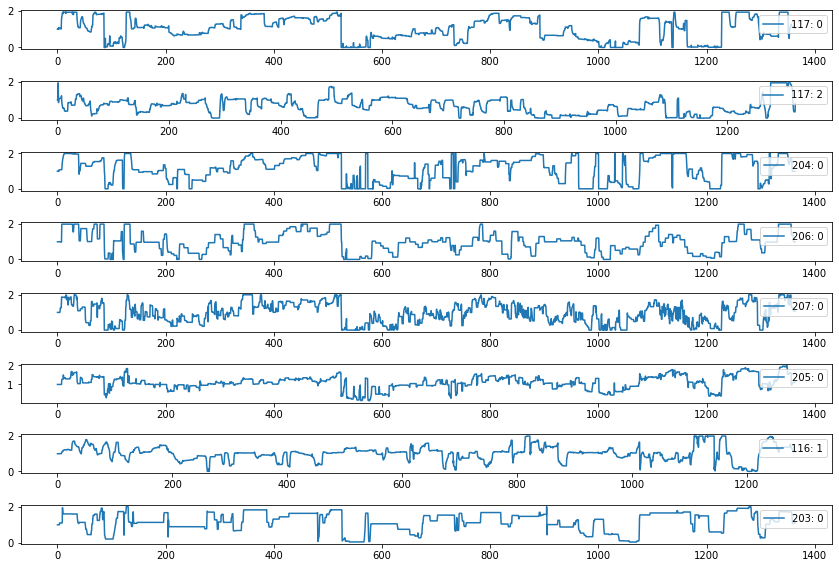

In [12]:
fig, axs = plt.subplots(nrows=len(dataset))

plt.tight_layout()

for i, ts in enumerate(dataset):
    axs[i].plot(
        ts.time,
        ts.signal,
        label=(ts.meta['participant']+": "+str(ts.meta['episode']))
    )
    
    axs[i].legend(loc='upper right')

plt.show()

In [13]:
# fig, axs = plt.subplots(nrows=len(dataset))

# for i, ts in enumerate(dataset):
# #     axs[i].plot(
# #         np.linspace(
# #             ts.time[0],
# #             ts.time[-1],
# #             num=len(ts.time)),
# #         ts.time,
# #         label=(ts.meta['participant'])
# #     )
#     print(
#         np.linspace(
#             ts.time[0],
#             ts.time[-1],
#         num=len(ts.time)),
#     )
    
# plt.legend(loc='upper right')

# plt.show()

In [14]:
dataset_cop = dataset

In [15]:
print("Preprocessing TimeSeries:")
print("==========")

bads = []

for i, ts in enumerate(tqdm(dataset)):
    try:
        # correct NaN values (done up top ^^^)
        # ts.fix_nan()

        # accommodate for skippy framerates
        # i.e. make ts.time a linear range
        ts.lag_correct()

        # sample to TR
        ts.resample(sample_rate=TR)
        
        # accommodate for skippy framerates
        # i.e. make ts.time a linear range
        ts.lag_correct()

        # chunking
        # ts.signal = ts.round_res()

        # center timeseries?
        ts.center()

        # smoothing (savgol filter)
        ts.savgol_filter(w=13, poly_order=3)
        
    except:
        print("Error @", ts.meta, ": skipping.")
        bads.append(i)
        print(i)
        continue
        
while len(bads) > 0:
    dataset.pop(max(bads))
    bads.pop(bads.index(max(bads)))

Preprocessing TimeSeries:


100%|██████████| 8/8 [00:00<00:00, 164.06it/s]


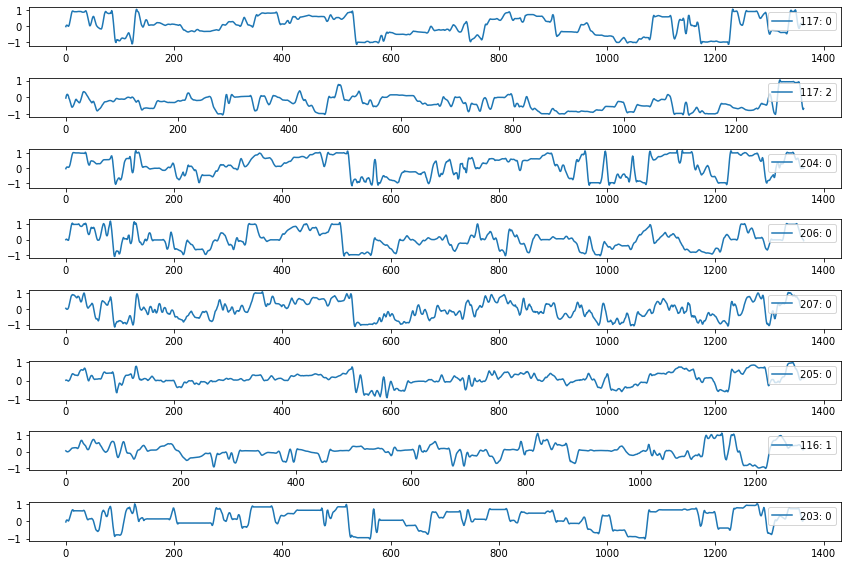

In [16]:
fig, axs = plt.subplots(nrows=len(dataset))

plt.tight_layout()

for i, ts in enumerate(dataset):
    axs[i].plot(
        ts.time,
        ts.signal,
        label=(ts.meta['participant']+": "+str(ts.meta['episode']))
    )
    
    axs[i].legend(loc='upper right')

plt.show()

Inspecting Lengths of Ratings in Each Episode:


100%|██████████| 3/3 [00:00<00:00, 106.30it/s]


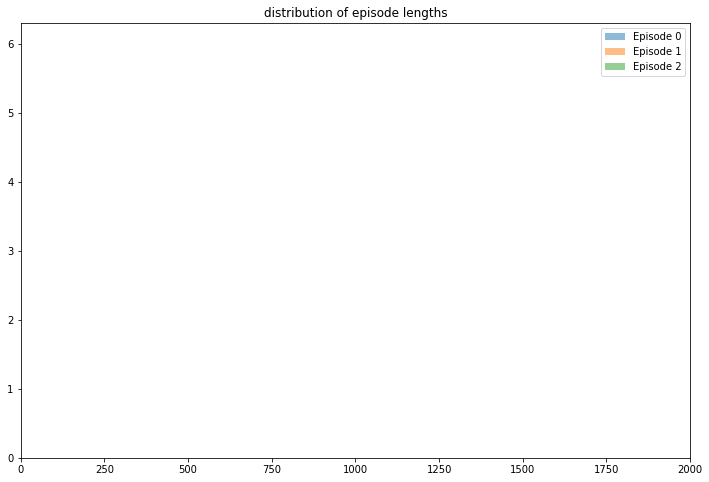

In [17]:
print("Inspecting Lengths of Ratings in Each Episode:")
print("==========")
episodes = []

for episode in tqdm(list(set([int(ts.meta['episode']) for ts in dataset]))):
    episodes.append(episode)
    plt.hist(
        [ts.time[-1] for ts in dataset\
        if ts.meta['episode']==episode],
        alpha=0.5,
        label="Episode "+str(episode))
    
plt.xlim(0, 2000)
plt.title("distribution of episode lengths")
plt.legend()

In [18]:
for episode in tqdm(list(set([int(ts.meta['episode']) for ts in dataset]))):
    for ts in [ts for ts in dataset \
        if ts.meta['episode']==episode]:
        print(
            "episode:",
            ts.meta['episode'],
            "\t",
            "participant ID:",
            ts.meta['participant'],
            "\t",
            "participant name:",
            participant_keyring[ts.meta['participant']][0],
            "\t",
            "length:",
            len(ts.signal))

100%|██████████| 3/3 [00:00<00:00, 2518.09it/s]

episode: 0 	 participant ID: 117 	 participant name: Susan 	 length: 1705
episode: 0 	 participant ID: 204 	 participant name: Amanda 	 length: 1705
episode: 0 	 participant ID: 206 	 participant name: Shreeja 	 length: 1705
episode: 0 	 participant ID: 207 	 participant name: Emma 	 length: 1705
episode: 0 	 participant ID: 205 	 participant name: Sarah 	 length: 1705
episode: 0 	 participant ID: 203 	 participant name: Emily 	 length: 1705
episode: 1 	 participant ID: 116 	 participant name: Susan 	 length: 1605
episode: 2 	 participant ID: 117 	 participant name: Susan 	 length: 1652


In [19]:
print(episodes)

[0, 1, 2]


Gold Standard ATV Rating:


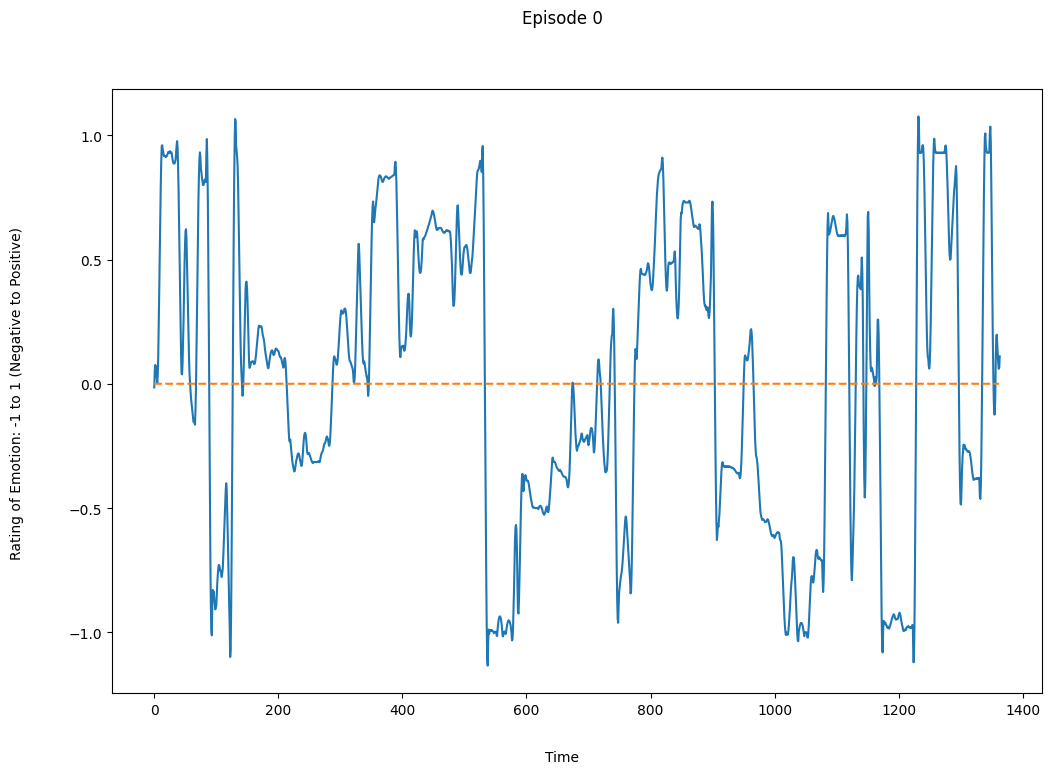

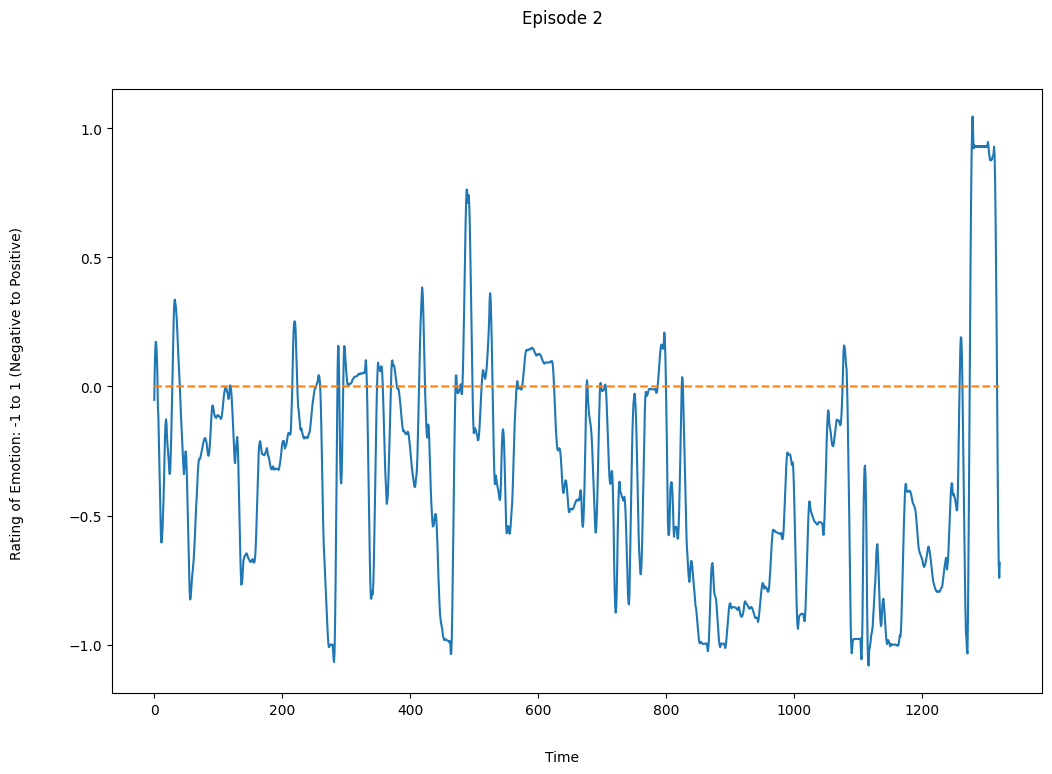

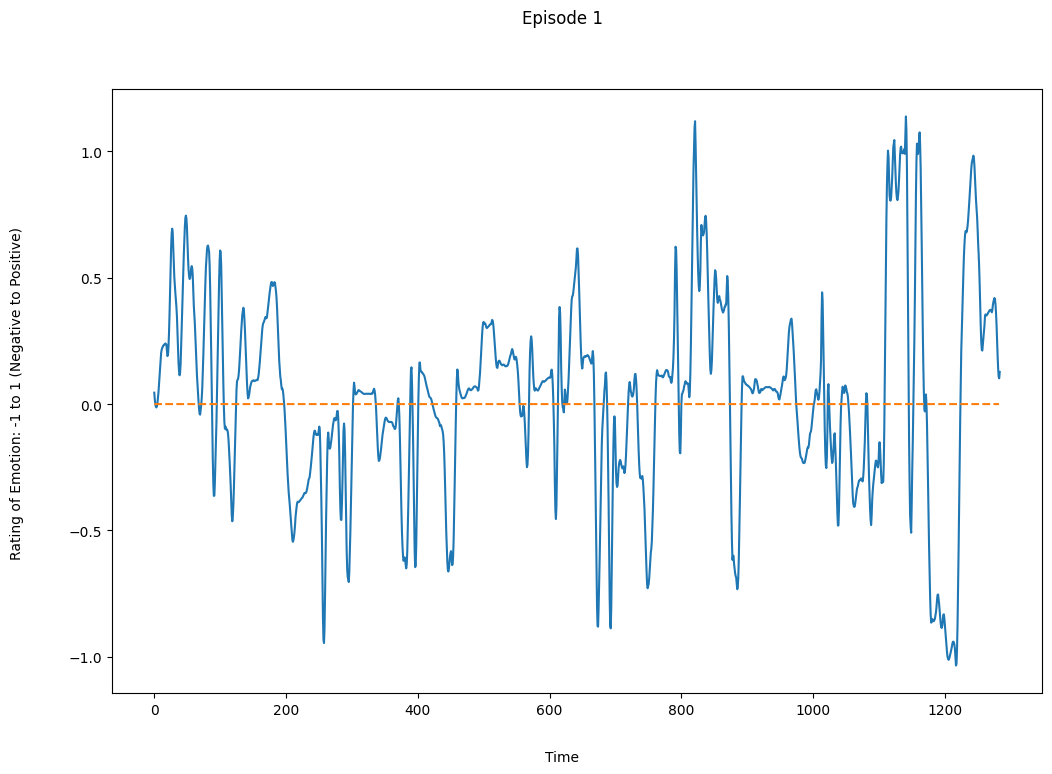

In [20]:
print("Gold Standard ATV Rating:")
print("==========")

gold_standard = "Susan"

gold = [ts for ts in dataset \
    if participant_keyring[ts.meta['participant']][0] == gold_standard ]

for ts in gold:
    Plots.plot_xy_line(
        ts.time,
        ts.signal,
        ylabel="Rating of Emotion: -1 to 1 (Negative to Positive)",
        plot_axis=np.zeros(round(ts.time[-1])),
        title="Episode "+str(ts.meta['episode']))

Inspecting Lengths of Ratings in Each Episode After Dropping:


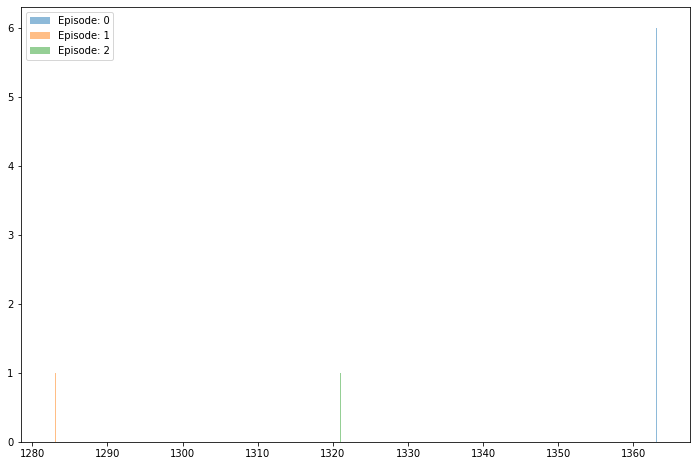

In [21]:
print("Inspecting Lengths of Ratings in Each Episode After Dropping:")
print("==========")

dataset = [ts for ts in dataset if ts.time[-1] > 1000]

for episode in episodes:
    
    plt.hist([ts.time[-1] for ts in dataset\
        if ts.meta['episode']==episode],
        alpha=0.5,
        label="Episode: "+str(episode))
plt.legend()

In [22]:
for episode in tqdm(list(set([ts.meta['episode'] for ts in dataset]))):
    for ts in [ts for ts in dataset \
        if ts.meta['episode']==episode]:
        print(
            "episode:",
            ts.meta['episode'],
            "\t",
            "participant ID:",
            ts.meta['participant'],
            "\t",
            "participant name:",
            participant_keyring[ts.meta['participant']][0],
            "\t",
            "length:",
            len(ts.signal))

100%|██████████| 3/3 [00:00<00:00, 1395.00it/s]

episode: 0 	 participant ID: 117 	 participant name: Susan 	 length: 1705
episode: 0 	 participant ID: 204 	 participant name: Amanda 	 length: 1705
episode: 0 	 participant ID: 206 	 participant name: Shreeja 	 length: 1705
episode: 0 	 participant ID: 207 	 participant name: Emma 	 length: 1705
episode: 0 	 participant ID: 205 	 participant name: Sarah 	 length: 1705
episode: 0 	 participant ID: 203 	 participant name: Emily 	 length: 1705
episode: 1 	 participant ID: 116 	 participant name: Susan 	 length: 1605
episode: 2 	 participant ID: 117 	 participant name: Susan 	 length: 1652


In [23]:
print("Matching Lengths and Discretizing the Dataset By Episode with Averages of Each:")
print("==========")

episodes = []
d_dataset = {}
d_avgs = {}
# truncate each batch of runs with the same episode to the length of the
# shortest trial in the batch
for episode in tqdm(list(set([ts.meta['episode'] for ts in dataset]))):
    episodes.append(episode)
    
    if len(list(set([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode]))) > 1:
        
        ep_min = min([len(ts.signal) for ts in dataset\
            if ts.meta['episode']==episode and ts.time[-1] > min_episode_samples])

        # here is the trimming portion
        for ts in [ts for ts in dataset if ts.meta['episode']==episode]:
            ts.signal = ts.signal[:ep_min]
            ts.time = ts.time[:ep_min]
        
    # discretize the dataset to a dict with entry for each episode
    d_dataset[episode] = [ts for ts in dataset if ts.meta['episode'] == episode]
    # make averages (discretized) of each episode's runs (same struc as d_dataset)
    d_avgs[episode] = TimeSeries.TimeSeries(
        signal=np.average(np.array([ts.signal for ts in d_dataset[episode]]), axis=0),
        time=d_dataset[episode][0].time,
        meta={
            'participant': 'AVG',
            'episode': episode})

Matching Lengths and Discretizing the Dataset By Episode with Averages of Each:


100%|██████████| 3/3 [00:00<00:00, 3115.35it/s]


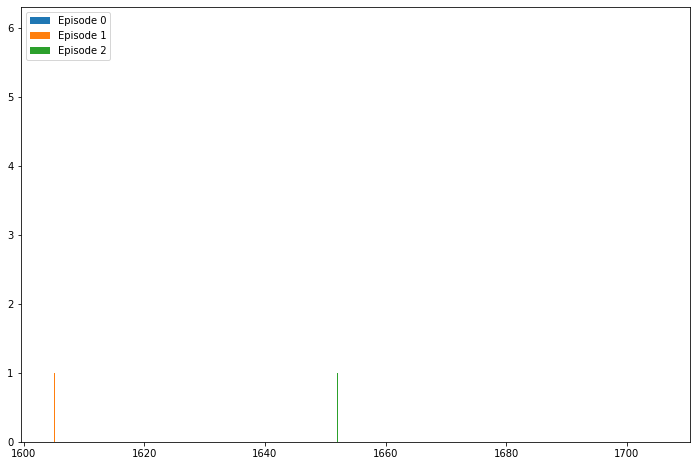

In [24]:
for episode in episodes:
    plt.hist(
        [len(ts.signal) for ts in d_dataset[episode]],
        label="Episode "+str(episode))
plt.legend()

In [25]:
# just view the structure of this object
print(d_dataset)
print(d_avgs)

{0: [<preprocessing.src.TimeSeries.TimeSeries object at 0x7f5d2b950790>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f5d2b958f50>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f5d2b97c690>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f5d2b90bdd0>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f5d2b958d90>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f5d2b9170d0>], 1: [<preprocessing.src.TimeSeries.TimeSeries object at 0x7f5d2b97c5d0>], 2: [<preprocessing.src.TimeSeries.TimeSeries object at 0x7f5d2b950c10>]}
{0: <preprocessing.src.TimeSeries.TimeSeries object at 0x7f5cb460bb50>, 1: <preprocessing.src.TimeSeries.TimeSeries object at 0x7f5cb4e74490>, 2: <preprocessing.src.TimeSeries.TimeSeries object at 0x7f5cb4e74290>}


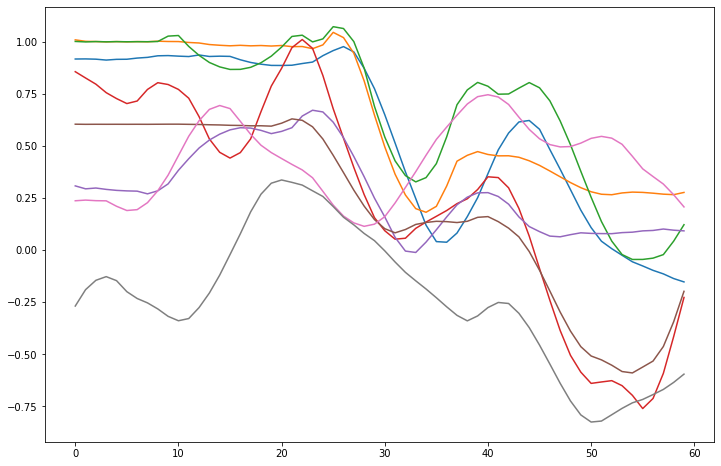

In [26]:
for episode in episodes:
    for ts in d_dataset[episode]:
        plt.plot(ts.signal[20:80])

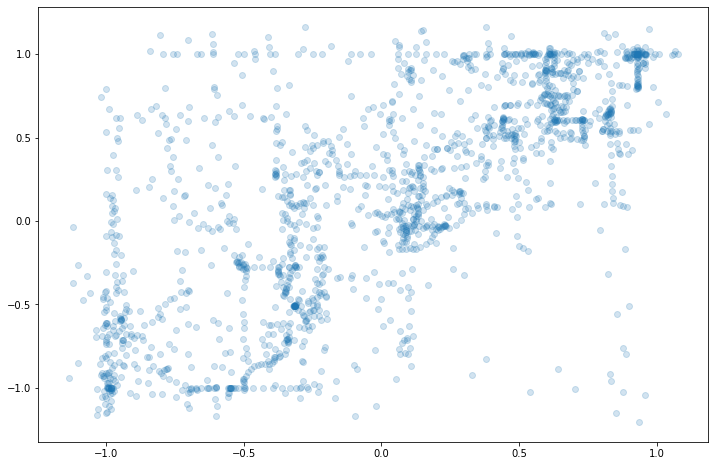

In [27]:
plt.scatter(
    d_dataset[0][0].signal,
    d_dataset[0][1].signal,
    alpha=0.2)

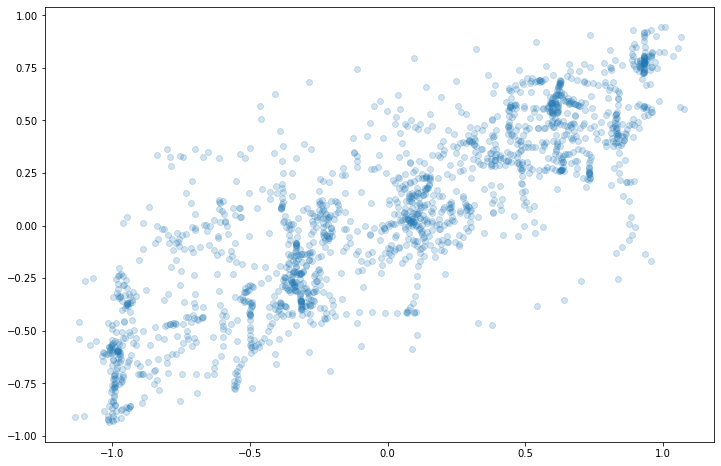

In [28]:
plt.scatter(
    d_dataset[0][0].signal,
    d_avgs[0].signal,
    alpha=0.2)

In [29]:
d_dataset[0][0].__dict__

{'signal': array([-0.0148039 ,  0.05171615,  0.07549623, ...,  0.06002666,
         0.06539506,  0.11007924]),
 'time': array([0.00000000e+00, 7.99882629e-01, 1.59976526e+00, ...,
        1.36140023e+03, 1.36220012e+03, 1.36300000e+03]),
 'sampleRate': 59.91744577028788,
 'meta': {'participant': '117', 'episode': 0, 'viewingOrder': 'ACB'},
 'unit': 's'}

In [30]:
Statistics.ping_icc([
    d_dataset[0][0],
    d_dataset[0][1]])

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.661188,4.902987,1704,1705,2.478193e-215,"[0.63, 0.69]"
1,ICC2,Single random raters,0.664640,5.220155,1704,1704,8.657736e-231,"[0.61, 0.71]"
2,ICC3,Single fixed raters,0.678465,5.220155,1704,1704,8.657736e-231,"[0.65, 0.7]"
3,ICC1k,Average raters absolute,0.796043,4.902987,1704,1705,2.478193e-215,"[0.78, 0.81]"
4,ICC2k,Average random raters,0.798539,5.220155,1704,1704,8.657736e-231,"[0.76, 0.83]"
5,ICC3k,Average fixed raters,0.808435,5.220155,1704,1704,8.657736e-231,"[0.79, 0.83]"


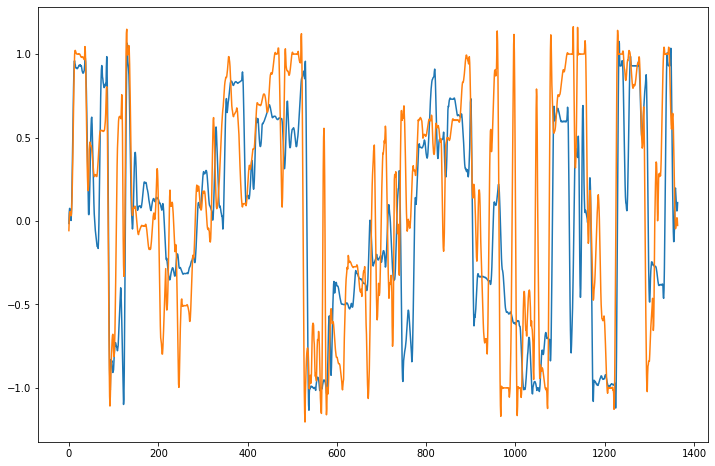

In [31]:
plt.plot(d_dataset[0][0].time, d_dataset[0][0].signal)
plt.plot(d_dataset[0][1].time, d_dataset[0][1].signal)

In [32]:
# initialize empty array for icc values (one per timepoint)
icc_dfs = {}
icc_vals = {}

for episode in episodes[:1]:
    
    # labels are all participants for episode + 'avg'
    xticklabels = list(set([ts.meta['participant'] for ts in d_dataset[episode]]))
    xticklabels.append('avg')
    yticklabels = deepcopy(xticklabels)
    
    df = pd.DataFrame(
        columns=xticklabels,
        index=yticklabels)
    
    
    for j, row in enumerate(df.index):
        for i, col in enumerate(df.columns):
        
            # case that we are in upper-right triangle of matrix
            if i > j:
                # grab ts1
                if col == 'avg':
                    ts1 = d_avgs[episode]
                else:
                    # the index of the dataset where the participant is col
                    ts1 = d_dataset[episode][[ts.meta['participant'] for ts in d_dataset[episode]].index(col)]
                    
                # grab ts2
                if row == 'avg':
                    ts2 = d_avgs[episode]
                else:
                    # the index of the dataset where the participant is row
                    ts2 = d_dataset[episode][[ts.meta['participant'] for ts in d_dataset[episode]].index(row)]

                try:
                    # compute ICC between ts1 and ts2
                    icc = Statistics.ping_icc([ts1, ts2])

                    df.iat[j, i] = icc.iat[0,2]
                    
                    # if significance
                    # if icc.iat[0, 6] < 0.05:
                        # df.iat[j, i] = df.iat[j, i]+"*"
                    
                except:
                    df.iat[j, i] = 0
                    print("Err @ row ", j, "col", i)
                    
            # case we are on diagonal
            elif i == j:
                df.iat[j, i] = 1
                
            # case that we are in bottom-left triangle of matrix
            else:
                df.iat[j, i] = df.iat[i, j]
            
    icc_dfs[episode] = df
    
    # do icc for whole set of them (not including average)
    icc = Statistics.ping_icc(d_dataset[episode])
    icc_vals[episode] = icc.iat[0,2].round(2)

In [33]:
icc_dfs[0]

,206,204,207,117,205,203,avg
206,1,0.496038,0.536708,0.414071,0.332015,0.365697,0.650658
204,0.496038,1,0.661695,0.661188,0.577149,0.715811,0.820611
207,0.536708,0.661695,1,0.745093,0.558018,0.54862,0.830855
117,0.414071,0.661188,0.745093,1,0.590537,0.564333,0.805225
205,0.332015,0.577149,0.558018,0.590537,1,0.570263,0.778001
203,0.365697,0.715811,0.54862,0.564333,0.570263,1,0.776681
avg,0.650658,0.820611,0.830855,0.805225,0.778001,0.776681,1


In [34]:
cmatrix = np.array(icc_dfs[0]).astype(float)

In [35]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

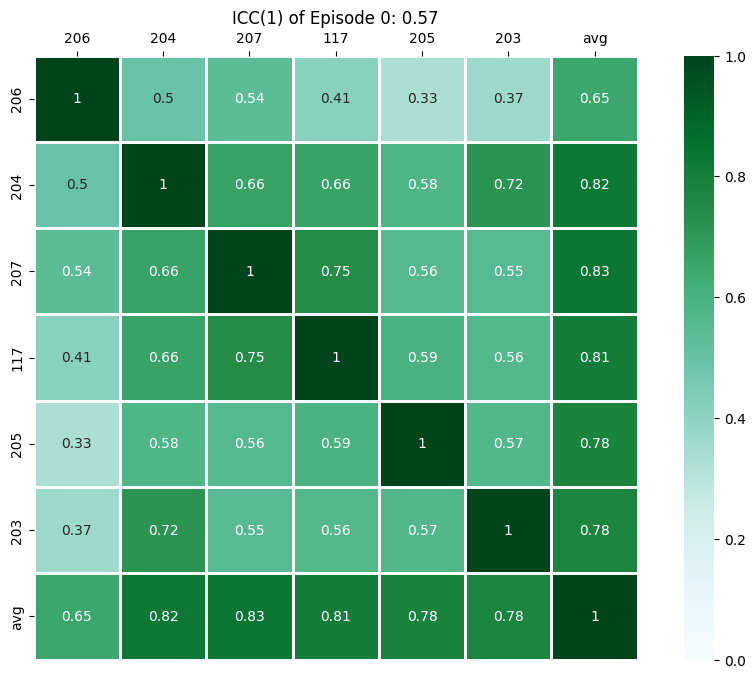

In [36]:
plot_episode = 0

ax = sns.heatmap(
    cmatrix,
    annot=True,
    xticklabels=[str(col) for col in icc_dfs[plot_episode].columns],
    yticklabels=[str(ind) for ind in icc_dfs[plot_episode].index],
#     cmap=sns.diverging_palette(20, 220, n=200),
    cmap="BuGn",
    linewidths=1,
    square=True,
    vmin=0,
    vmax=1)

ax.set_title("ICC(1) of Episode {}: {}".format(plot_episode, icc_vals[plot_episode]))
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

# ax.set_xticklabels(
#     [str(col) for col in iccs[0].columns],
#     rotation=45,
#     horizontalalignment='right')

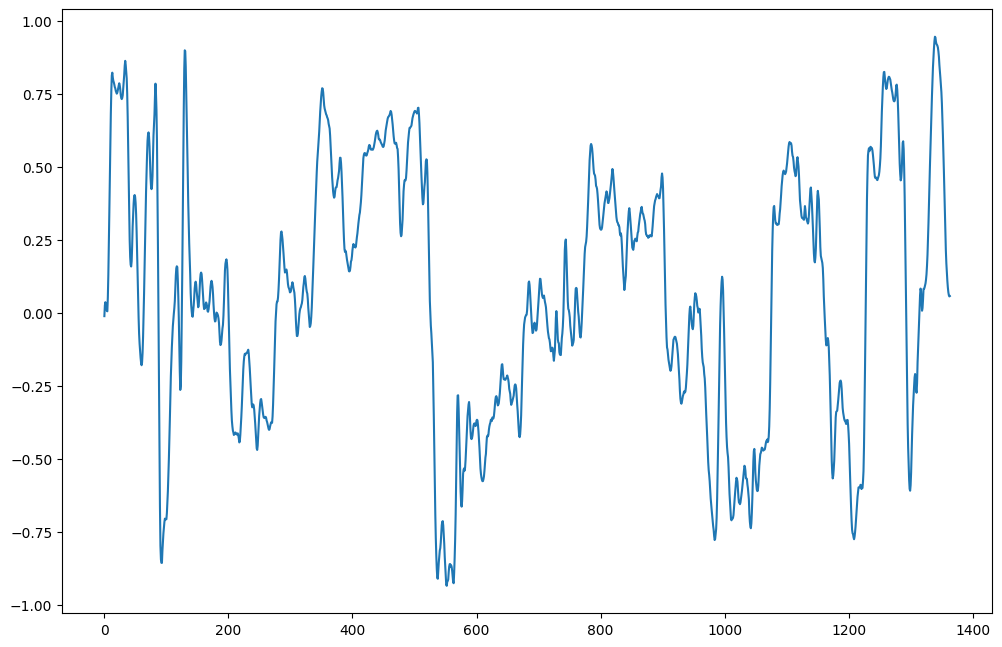

In [37]:
plt.plot(
    d_avgs[0].time,
    d_avgs[0].signal)

In [38]:
d_avgs[0].signal

array([-0.01093121,  0.02584088,  0.03693462, ...,  0.06101018,
        0.05655966,  0.05782573])

In [39]:
len(d_avgs[0].signal)

1705

In [41]:
f = open('/data/perlman/moochie/analysis/CARE/AHKJ_rating_avg_0.txt', 'w')

for i, val in enumerate(d_avgs[0].signal):
    if i > 0:
        f.write('\n')
    f.write(str(val))
    
f.close()

In [30]:
total_len = 0

for episode in episodes:
    total_len += list(set([len(ts.signal) for ts in d_dataset[episode]]))[0]
    
print("Ideal concatenated length:", total_len, "samples.")

Ideal concatenated length: 3174 samples.


In [47]:
# concat each episode to each other ep for that participant?

c_dataset = {}

for i, episode in enumerate(episodes):
    
    for ts in d_dataset[episode]:
        if participant_keyring[ts.meta['participant']][0] not in c_dataset:
            c_dataset[participant_keyring[ts.meta['participant']][0]] = ts.signal
        else:
            c_dataset[participant_keyring[ts.meta['participant']][0]] = np.concatenate((
                c_dataset[participant_keyring[ts.meta['participant']][0]],
                ts.signal))

In [48]:
len(c_dataset)

16

In [49]:
# only get those who have all 3 episodes

c_dataset = {
    sub: c_dataset[sub] for sub in c_dataset.keys() if len(c_dataset[sub]) == total_len}

In [51]:
# appears to be all of them here. great
len(c_dataset)

16

In [ ]:
iccs = []

for sub in c_dataset.keys():
    if sub is not "Susan":
        print(sub)
        iccs.append(Statistics.ping_icc([ts1, ts2]))

In [53]:
from scipy.signal import savgol_filter

In [55]:
y_filtered = savgol_filter(
    c_dataset['Susan'],
    window_length=13,
    polyorder=3
)

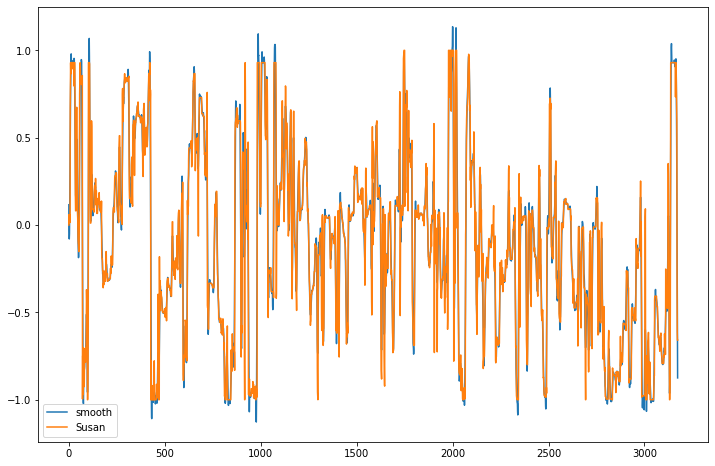

In [65]:
plt.plot(y_filtered, label='smooth')
plt.plot(c_dataset['Susan'], label='Susan')
plt.legend()

In [66]:
f = open("/data/perlman/moochie/analysis/CARE/AHKJ_rating.txt", 'w')

for i, val in enumerate(y_filtered):
    if i > 0:
        f.write('\n')
    f.write(str(val))
    
f.close()